# **Responsible Data Science Final Project**

by Sangwon Baek and Simone Rittenhouse

ADS System: [Home Credit Default Risk Prediction](https://www.kaggle.com/c/home-credit-default-risk)

(uses logistic regression and a random forest model to compute risk predictions)

Solution by Will Koehrsen: found [here](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction)

Data provided [here](https://www.kaggle.com/c/home-credit-default-risk/data)

# **ADS Solution (by Will Koehrsen):**

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

FileNotFoundError: ignored

In [ ]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# NOTE: Storing labels for LIME
label_names = {}

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            label_names[col] = le.classes_
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [ ]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# (NOTE: This was added to have labels to assess model performance on a new test set)
from sklearn import model_selection
train, test, train_labels, test_labels = model_selection.train_test_split(train, train_labels, test_size=0.30, random_state=0)
applicant_id = test[['SK_ID_CURR']]

# Median imputation of missing values 
# (NOTE: We changed this to SimpleImputer from Imputer since it was removed in sklearn)
# original code: imputer = Imputer(strategy = 'median')
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test) # changed from .transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (215257, 240)
Testing data shape:  (92254, 240)


**ADS implementing Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

In [ ]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [ ]:
# Submission dataframe
#submit_log = app_test[['SK_ID_CURR']]
submit_log = applicant_id.copy()
submit_log['TARGET'] = log_reg_pred

# Save the submission to a csv file
submit_log.to_csv('log_reg_baseline.csv', index = False)

submit_log.head()

,SK_ID_CURR,TARGET
42962,149741,0.092161
227307,363290,0.065269
290035,436006,0.068388
239833,377703,0.104377
76427,188624,0.097982


**ADS implementing Random Forest Classification**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.7s finished


In [ ]:
# Make a submission dataframe
#submit_forest = app_test[['SK_ID_CURR']]
submit_forest = applicant_id.copy()
submit_forest['TARGET'] = predictions

# Save the submission dataframe
submit_forest.to_csv('random_forest_baseline.csv', index = False)

submit_forest.head()

,SK_ID_CURR,TARGET
42962,149741,0.21
227307,363290,0.04
290035,436006,0.04
239833,377703,0.05
76427,188624,0.24


# **Input and Output: Data Profiling and Exploratory Analysis**

**Exploratory Analysis:**

In [ ]:
# getting training/test data (before the ADS processed it)
dfTrain = pd.read_csv('application_train.csv')
dfTest = pd.read_csv('application_test.csv')

# SPLIT DATA HERE
dfTrain, dfTest = model_selection.train_test_split(dfTrain, test_size=0.30, random_state=0)
print('Training Data Shape:', dfTrain.shape)
print('Testing Data Shape:', dfTest.shape)

# seeing data types in training data set
print('\nINPUT DATA TYPES:')
print(dfTrain.dtypes.value_counts(), '\n')

dfTrain.describe()

Training Data Shape: (215257, 122)
Testing Data Shape: (92254, 122)

INPUT DATA TYPES:
float64    65
int64      41
object     16
dtype: int64 



,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,215257.000000,215257.000000,215257.000000,2.152570e+05,2.152570e+05,215247.000000,2.150630e+05,215257.000000,215257.000000,215257.000000,...,215257.000000,215257.000000,215257.000000,215257.000000,186305.000000,186305.000000,186305.000000,186305.000000,186305.000000,186305.000000
mean,278319.341085,0.081228,0.415178,1.689097e+05,5.996548e+05,27138.545861,5.389279e+05,0.020865,-16043.176171,63906.197099,...,0.008079,0.000581,0.000530,0.000279,0.006237,0.006854,0.034331,0.267545,0.263541,1.899348
std,102722.225330,0.273186,0.720177,2.758216e+05,4.033257e+05,14535.303864,3.701608e+05,0.013841,4365.095218,141353.827451,...,0.089518,0.024091,0.023007,0.016693,0.082523,0.108278,0.203621,0.915900,0.610491,1.867110
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17583.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189350.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16560.000000,2.385000e+05,0.010006,-19692.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278399.000000,0.000000,0.000000,1.458000e+05,5.135310e+05,24939.000000,4.500000e+05,0.018850,-15767.000000,-1217.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367250.000000,0.000000,1.000000,2.025000e+05,8.086500e+05,34618.500000,6.795000e+05,0.028663,-12417.000000,-290.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,24.000000,19.000000,22.000000


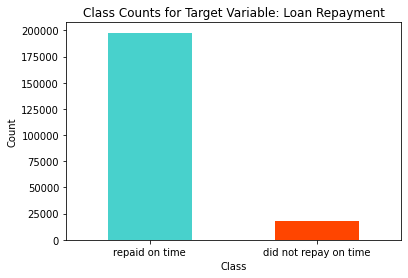

In [ ]:
# seeing true values in training data (0 = repaid loan on time, 1 = had trouble repaying on time)
dfTrain['TARGET'].value_counts().plot(kind = 'bar', color = ['mediumturquoise', 'orangered'])
plt.title('Class Counts for Target Variable: Loan Repayment')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(ticks = [0,1], labels = ['repaid on time', 'did not repay on time'], rotation = 0)
plt.show()

**Examining Missing Values:**

In [ ]:
# examining missing values in training data

nulls = pd.DataFrame(dfTrain.isnull().sum(), columns = ['Num Missing'])
nulls = nulls[nulls['Num Missing'] > 0]
nulls['Percent Total'] = round((nulls['Num Missing'] / dfTrain.shape[0]) * 100, 2)

print('Total Features with missing values in training data:', len(nulls))
print('Percentage of features with missing values: {:.2%}'.format(len(nulls)/len(dfTrain.columns)))

print('\nFeatures with most missing values:')
nulls.sort_values(by = 'Num Missing', ascending = False).head(20)

Total Features with missing values in training data: 67
Percentage of features with missing values: 54.92%

Features with most missing values:


,Num Missing,Percent Total
COMMONAREA_MEDI,150436,69.89
COMMONAREA_AVG,150436,69.89
COMMONAREA_MODE,150436,69.89
NONLIVINGAPARTMENTS_MEDI,149553,69.48
NONLIVINGAPARTMENTS_MODE,149553,69.48
NONLIVINGAPARTMENTS_AVG,149553,69.48
FONDKAPREMONT_MODE,147351,68.45
LIVINGAPARTMENTS_MODE,147236,68.40
LIVINGAPARTMENTS_MEDI,147236,68.40
LIVINGAPARTMENTS_AVG,147236,68.40


**Correlations Between Several Important Features and the Outcome Variable:**

In [ ]:
# seeing which features are most important in ADS prediction:

feature_importances.sort_values(by = 'importance', ascending = False).head()

,feature,importance
32,EXT_SOURCE_2,0.049206
33,EXT_SOURCE_3,0.046323
10,DAYS_BIRTH,0.032060
13,DAYS_ID_PUBLISH,0.031402
12,DAYS_REGISTRATION,0.031051


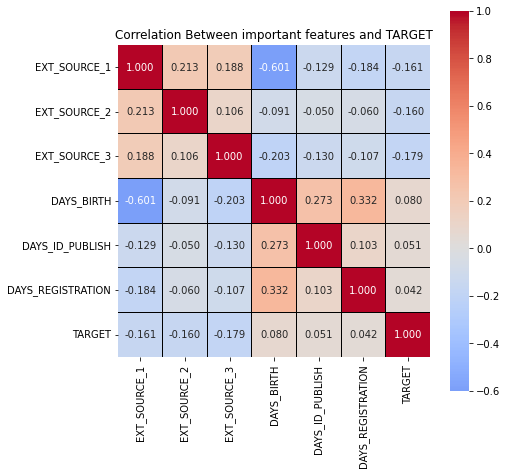

In [ ]:
# correlations of important features with target
corr = dfTrain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'TARGET']].corr()
plt.figure(figsize = (7,7))
palette = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, annot=True, square=True, cmap = palette, center = 0,
            linewidth = 0.1, linecolor='black', fmt='.3f')
plt.title('Correlation Between important features and TARGET')
plt.show()

**Examining the Distributions of Several Features:**

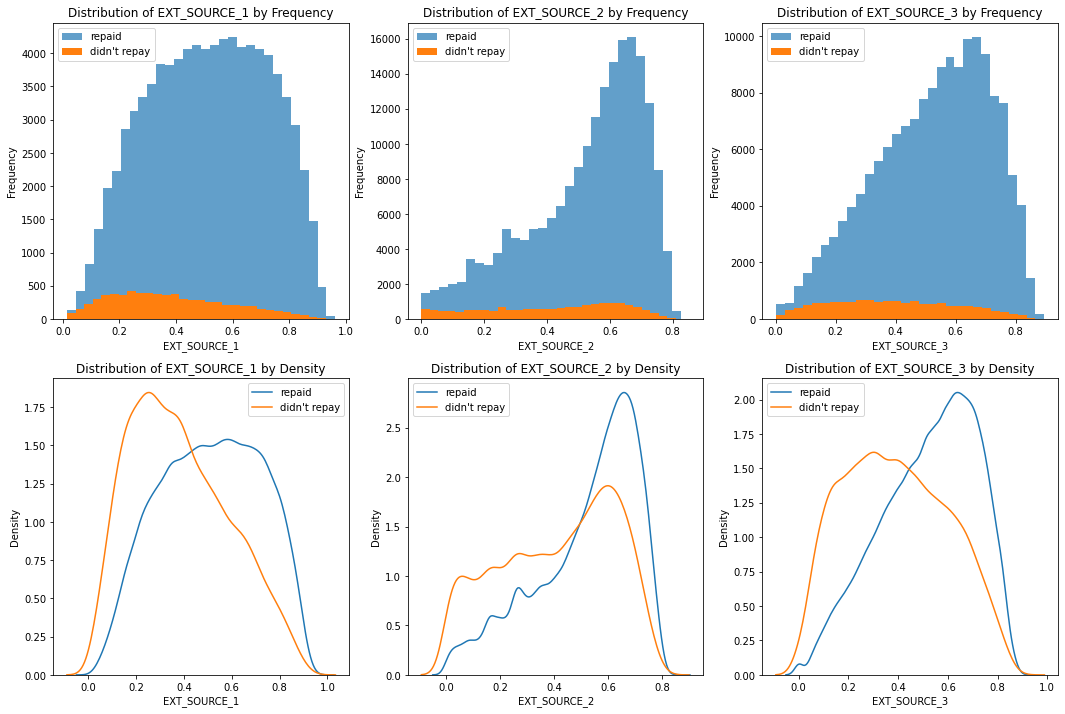

In [ ]:
# seeing distributions of EXT_SOURCE features by TARGET value

# plotting histograms
ext_sources = dfTrain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
titles = list(enumerate(ext_sources))

fig, axs = plt.subplots(2, ext_sources.shape[1], figsize = (18,12))
for row in range(2):
  for i, feature in enumerate(ext_sources):
    if row == 0:
      # by frequency
      axs[row,i].hist(ext_sources[dfTrain['TARGET'] == 0][feature], bins = 30, label = 'repaid', alpha = 0.7)
      axs[row,i].hist(ext_sources[dfTrain['TARGET'] == 1][feature], bins = 30, label = "didn't repay")
      axs[row,i].legend(loc='best')
      axs[row,i].set(title = 'Distribution of '+ titles[i][1] + ' by Frequency', xlabel = titles[i][1], ylabel = 'Frequency')
    else:
      # by density
      sns.kdeplot(ext_sources[dfTrain['TARGET'] == 0][feature], label = 'repaid', ax = axs[row,i])
      sns.kdeplot(ext_sources[dfTrain['TARGET'] == 1][feature], label = "didn't repay", ax = axs[row,i])
      axs[row,i].legend(loc='best')
      axs[row,i].set(title = 'Distribution of '+ titles[i][1] + ' by Density', xlabel = titles[i][1], ylabel = 'Density')

plt.show()

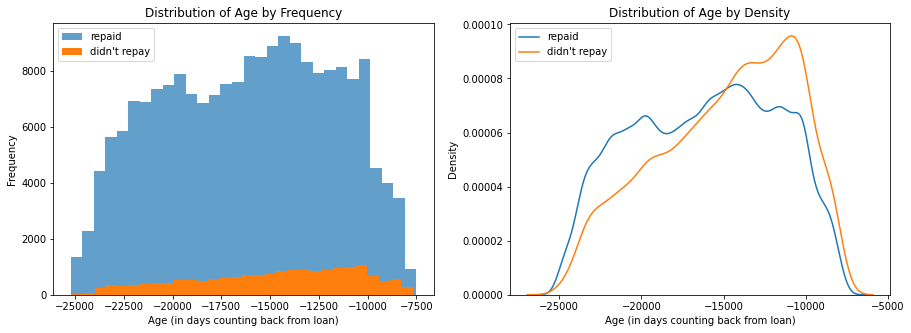

In [ ]:
# distribution of age in training data and test data for TARGET == 0 and TARGET == 1

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(dfTrain[dfTrain['TARGET'] == 0]['DAYS_BIRTH'], bins = 30, label = 'repaid', alpha = 0.7)
plt.hist(dfTrain[dfTrain['TARGET'] == 1]['DAYS_BIRTH'], bins = 30, label = "didn't repay")
plt.title('Distribution of Age by Frequency')
plt.xlabel('Age (in days counting back from loan)')
plt.ylabel('Frequency')
plt.legend(loc = 'best')

plt.subplot(1,2,2)
sns.kdeplot(dfTrain[dfTrain['TARGET'] == 0]['DAYS_BIRTH'], label = 'repaid')
sns.kdeplot(dfTrain[dfTrain['TARGET'] == 1]['DAYS_BIRTH'], label = "didn't repay")
plt.title('Distribution of Age by Density')
plt.xlabel('Age (in days counting back from loan)')
plt.ylabel('Density')
plt.legend(loc = 'best')

plt.show()

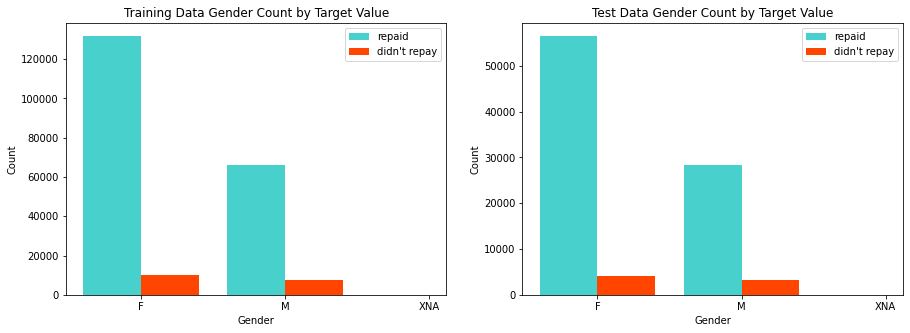


Percentage of Women (F) who didn't repay loan on time: 7.03%
Percentage of Men (M) who didn't repay loan on time: 10.23%


In [ ]:
# distribution of gender in training data and test data for TARGET == 0 and TARGET == 1

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
repayGenTrain = dfTrain[dfTrain['TARGET'] == 0]['CODE_GENDER'].value_counts()
plt.bar(np.arange(len(repayGenTrain))-0.2, repayGenTrain, width = 0.4, color = 'mediumturquoise', label = 'repaid')
noRepayGenTrain = dfTrain[dfTrain['TARGET'] == 1]['CODE_GENDER'].value_counts()
plt.bar(np.arange(len(noRepayGenTrain))+0.2, noRepayGenTrain, width = 0.4, color = 'orangered', label = "didn't repay")
plt.xticks(ticks = range(len(repayGenTrain)), labels = ['F', 'M', 'XNA'])
plt.legend(loc = 'best')
plt.title('Training Data Gender Count by Target Value')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.subplot(1,2,2)
repayGenTest = dfTest[dfTest['TARGET'] == 0]['CODE_GENDER'].value_counts()
plt.bar(np.arange(len(repayGenTest))-0.2, repayGenTest, width = 0.4, color = 'mediumturquoise', label = 'repaid')
noRepayGenTest = dfTest[dfTest['TARGET'] == 1]['CODE_GENDER'].value_counts()
plt.bar(np.arange(len(noRepayGenTest))+0.2, noRepayGenTest, width = 0.4, color = 'orangered', label = "didn't repay")
plt.xticks(ticks = range(len(repayGenTest)), labels = ['F', 'M', 'XNA'])
plt.legend(loc = 'best')
plt.title('Test Data Gender Count by Target Value')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

print("\nPercentage of Women (F) who didn't repay loan on time: {:.2%}".format(noRepayGenTrain[0]/len(dfTrain[dfTrain['CODE_GENDER'] == 'F'])))
print("Percentage of Men (M) who didn't repay loan on time: {:.2%}".format(noRepayGenTrain[1]/len(dfTrain[dfTrain['CODE_GENDER'] == 'M'])))

# **Outcomes: Examining Fairness and Diversity**

**Performance For Both Models:**

In [ ]:
true_labels = test_labels.to_numpy()

In [ ]:
from sklearn import metrics

log_preds = log_reg.predict(test)
rf_preds = random_forest.predict(test)

rf_auc = metrics.roc_auc_score(true_labels, predictions)
rf_acc = metrics.accuracy_score(true_labels, rf_preds)

print('\nAUC of Logistic Regression:', metrics.roc_auc_score(true_labels, log_reg_pred))
print('Accuracy of Logistic Regression:', metrics.accuracy_score(true_labels, log_preds))
print('\nAUC of Random Forest:', rf_auc)
print('Accuracy of Random Forest:', rf_acc);

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.7s



AUC of Logistic Regression: 0.6838337381132339
Accuracy of Logistic Regression: 0.9204370542198712

AUC of Random Forest: 0.7101081963421366
Accuracy of Random Forest: 0.9205129316885988


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.7s finished


In [ ]:
print('Confusion Matrix of Logistic Regression:')
log_confusion = pd.DataFrame(metrics.confusion_matrix(true_labels, log_preds),
                             columns = ['Predicted Repayment', 'Predicted No Repayment'],
                             index = ['Actual Repayment', 'Actual No Repayment'])
log_confusion

Confusion Matrix of Logistic Regression:


,Predicted Repayment,Predicted No Repayment
Actual Repayment,84914,0
Actual No Repayment,7340,0


In [ ]:
print('Confusion Matrix of Random Forest:')
rf_confusion = pd.DataFrame(metrics.confusion_matrix(true_labels, rf_preds),
                             columns = ['Predicted Repayment', 'Predicted No Repayment'],
                             index = ['Actual Repayment', 'Actual No Repayment'])
rf_confusion

Confusion Matrix of Random Forest:


,Predicted Repayment,Predicted No Repayment
Actual Repayment,84911,3
Actual No Repayment,7330,10


**Examining Demographics of Group Predicted to Not Repay:**

In [ ]:
# individuals predicted not to repay
rf_cantPay = pd.DataFrame(data=test[np.where(rf_preds == 1)][:,1:], 
                          columns = features[1:], 
                          index=applicant_id['SK_ID_CURR'].iloc[np.where(rf_preds == 1)[0]])

rf_cantPay

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
353102,0.0,0.0,1.0,0.000000,0.000935,0.148584,0.115620,0.102132,0.282797,0.094081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316358,0.0,0.0,1.0,0.000000,0.000666,0.052360,0.072675,0.046016,0.090864,0.016573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
292368,0.0,0.0,0.0,0.000000,0.001050,0.050506,0.071516,0.046016,0.309272,0.138613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275379,0.0,0.0,1.0,0.000000,0.001320,0.118921,0.104493,0.102132,0.421848,0.170688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184020,0.0,0.0,0.0,0.000000,0.001512,0.118921,0.117059,0.102132,0.254009,0.247971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368566,0.0,1.0,1.0,0.052632,0.000742,0.118049,0.092418,0.096521,0.268617,0.235231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156227,0.0,0.0,0.0,0.000000,0.000819,0.124854,0.102176,0.102132,0.196267,0.052368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232843,0.0,0.0,0.0,0.052632,0.001512,0.148584,0.115620,0.102132,0.344429,0.387599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217810,0.0,0.0,0.0,0.000000,0.000935,0.067697,0.074465,0.054994,0.276330,0.249662,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
print('GENDER FOR ENTIRE TEST SET: 1==Female, 0==Male')
print(pd.DataFrame(test, columns = features)['CODE_GENDER_F'].value_counts(), '\n')

print('GENDER FOR THOSE PREDICTED TO NOT REPAY: 1==Female, 0==Male')
print(rf_cantPay['CODE_GENDER_F'].value_counts())

GENDER FOR ENTIRE TEST SET: 1==Female, 0==Male
1.0    60733
0.0    31521
Name: CODE_GENDER_F, dtype: int64 

GENDER FOR THOSE PREDICTED TO NOT REPAY: 1==Female, 0==Male
0.0    7
1.0    6
Name: CODE_GENDER_F, dtype: int64


In [ ]:
print('INCOME FOR ENTIRE TEST SET')
print(pd.DataFrame(test, columns = features)['AMT_INCOME_TOTAL'].describe()[['min', 'max', 'mean']], '\n')

print('INCOME FOR THOSE PREDICTED TO NOT REPAY')
print(rf_cantPay['AMT_INCOME_TOTAL'].describe()[['min', 'max', 'mean']])

INCOME FOR ENTIRE TEST SET
min     0.000000
max     0.032480
mean    0.001222
Name: AMT_INCOME_TOTAL, dtype: float64 

INCOME FOR THOSE PREDICTED TO NOT REPAY
min     0.000666
max     0.002089
mean    0.001180
Name: AMT_INCOME_TOTAL, dtype: float64


In [ ]:
print('AGE FOR ENTIRE TEST SET')
print(pd.DataFrame(test, columns = features)['DAYS_BIRTH'].describe()[['min', 'max', 'mean']], '\n')

print('AGE FOR THOSE PREDICTED TO NOT REPAY')
print(rf_cantPay['DAYS_BIRTH'].describe()[['min', 'max', 'mean']])

AGE FOR ENTIRE TEST SET
min     0.010541
max     0.998196
mean    0.481036
Name: DAYS_BIRTH, dtype: float64 

AGE FOR THOSE PREDICTED TO NOT REPAY
min     0.016573
max     0.499154
mean    0.194073
Name: DAYS_BIRTH, dtype: float64


**Checking AUC and Accuracy for these Demographic Subgroups:**

In [ ]:
# adding Income subgroups (above and below median)
# 1 == 'Wealthier', 0 == 'Poorer'

incomeIndex = features.index('AMT_INCOME_TOTAL')

medIncome = np.median(test[:,incomeIndex])
highLowIncome = np.where(test[:,incomeIndex] > medIncome, 1, 0)

# adding Age subgroups (above and below median)
# 1 == 'Older', 0 == 'Younger'

ageIndex = features.index('DAYS_BIRTH')

medAge = np.median(test[:,ageIndex])
highLowAge = np.where(test[:,ageIndex] > medAge, 1, 0)

In [ ]:
def getSubgroup(featureName, value, condition=True, conditionalIndex=np.array([]), 
                predLabels=rf_preds, predProbs=predictions, trueLabels=test_labels):
  if condition:
    index = np.where(test[:,features.index(featureName)] == value)
  else:
    index = np.where(conditionalIndex == value)
  temp_preds = predLabels[index]
  temp_probs = predProbs[index]
  temp_target = trueLabels.iloc[index]

  acc = metrics.accuracy_score(temp_target, temp_preds)
  auc = metrics.roc_auc_score(temp_target, temp_probs)

  print('Accuracy of', featureName, '==', value, ':', acc)
  print('AUC of', featureName, '==', value, ':', auc)
  print()

  return acc, auc

# Gender
women_acc, women_auc = getSubgroup('CODE_GENDER_F', 1)
men_acc, men_auc = getSubgroup('CODE_GENDER_M', 1)

# Income
highIncome_acc, highIncome_auc = getSubgroup('INCOME', 1, False, highLowIncome)
lowIncome_acc, lowIncome_auc = getSubgroup('INCOME', 0, False, highLowIncome)

# Age
highAge_acc, highAge_auc = getSubgroup('AGE', 1, False, highLowAge)
lowAge_acc, lowAge_auc = getSubgroup('AGE', 0, False, highLowAge)

Accuracy of CODE_GENDER_F == 1 : 0.9307460523932624
AUC of CODE_GENDER_F == 1 : 0.7052483002406487

Accuracy of CODE_GENDER_M == 1 : 0.9007931472081219
AUC of CODE_GENDER_M == 1 : 0.7011726057148965

Accuracy of INCOME == 1 : 0.9248299542899635
AUC of INCOME == 1 : 0.7052689590045291

Accuracy of INCOME == 0 : 0.91627087318132
AUC of INCOME == 0 : 0.7137302875196442

Accuracy of AGE == 1 : 0.9371300973399528
AUC of AGE == 1 : 0.6862319328762023

Accuracy of AGE == 0 : 0.903895766037245
AUC of AGE == 0 : 0.7119984961932426



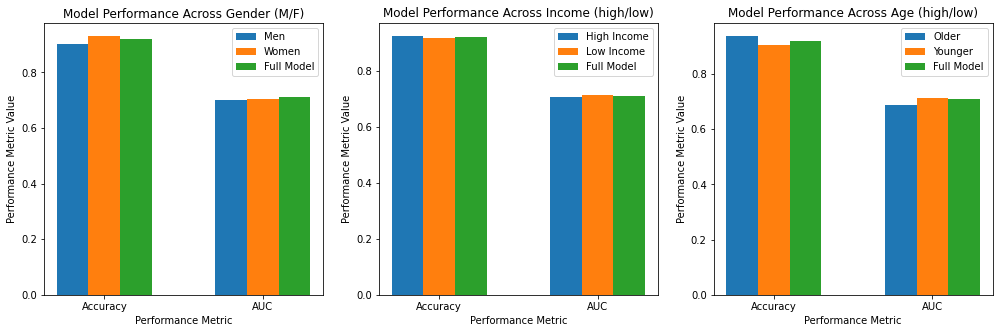

In [ ]:
# Plotting Results

plt.figure(figsize = (17, 5))

x = np.arange(2)  # the label locations
width = 0.2  # the width of the bars

plt.subplot(1,3,1)
plt.bar(x - width, [men_acc, men_auc], width, label='Men')
plt.bar(x, [women_acc, women_auc], width, label='Women')
plt.bar(x + width, [rf_acc, rf_auc], width, label='Full Model')
plt.legend(loc = 'best')
plt.xticks(x, ['Accuracy', 'AUC'])
plt.title('Model Performance Across Gender (M/F)')
plt.xlabel('Performance Metric')
plt.ylabel('Performance Metric Value')

plt.subplot(1,3,2)
plt.bar(x - width, [highIncome_acc, highIncome_auc], width, label='High Income')
plt.bar(x, [lowIncome_acc, lowIncome_auc], width, label='Low Income')
plt.bar(x + width, [rf_acc, rf_auc], width, label='Full Model')
plt.legend(loc = 'best')
plt.xticks(x, ['Accuracy', 'AUC'])
plt.title('Model Performance Across Income (high/low)')
plt.xlabel('Performance Metric')
plt.ylabel('Performance Metric Value')

plt.subplot(1,3,3)
plt.bar(x - width, [highAge_acc, highAge_auc], width, label='Older')
plt.bar(x, [lowAge_acc, lowAge_auc], width, label='Younger')
plt.bar(x + width, [rf_acc, rf_auc], width, label='Full Model')
plt.legend(loc = 'best')
plt.xticks(x, ['Accuracy', 'AUC'])
plt.title('Model Performance Across Age (high/low)')
plt.xlabel('Performance Metric')
plt.ylabel('Performance Metric Value')

plt.show()

**Fairness and Diversity Measures:**

In [ ]:
!pip install aif360==0.3.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 165 kB 5.4 MB/s 


In [ ]:
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

In [ ]:
# making new test and pred dataframe

test_df = pd.DataFrame(test, columns=features)
test_df['HighLowAge'] = highLowAge
test_df['Target'] = true_labels

preds_df = test_df.copy()
preds_df['Target'] = rf_preds

In [ ]:
def transform_to_aif(df, protected_attr, target='Target'):
  '''convert a pandas.DataFrame to a StandardDataset used in AIF360'''

  sd = StandardDataset(
      df,
      label_name = target,
      favorable_classes = [1],
      protected_attribute_names = [protected_attr],
      privileged_classes = [[1]]
  )

  return sd

**Evaluating Fairness for Gender**

Privileged = Women

Unprivileged = Men

Men were predicted to be unable to repay a loan at a higher rate than women, making them less privileged for the random forest model. Here, we'll evaluate how biased the model may be against them.

In [ ]:
protected_attr = 'CODE_GENDER_F'

privileged_group = [{protected_attr: 1}] 
unprivileged_group = [{protected_attr: 0}]

In [ ]:
AIF_test_Gender = transform_to_aif(test_df, protected_attr)
AIF_pred_Gender = transform_to_aif(preds_df, protected_attr)

test_vs_preds_metrics = ClassificationMetric(AIF_test_Gender, AIF_pred_Gender,
                                             unprivileged_groups=unprivileged_group,
                                             privileged_groups=privileged_group)

In [ ]:
# FAIRNESS METRICS

print('Mean Difference:', test_vs_preds_metrics.mean_difference())
print('Disparate Impact:', test_vs_preds_metrics.disparate_impact())

print('\nERRORS:')
print('False-Positive Rate for Men:', test_vs_preds_metrics.false_positive_rate(privileged = False))
print('False-Positive Rate for Women:', test_vs_preds_metrics.false_positive_rate(privileged = True))
print('False-Positive Rate Difference:', test_vs_preds_metrics.false_positive_rate_difference())

print('\nFalse-Negative Rate for Men:', test_vs_preds_metrics.false_negative_rate(privileged = False))
print('False-Negative Rate for Women:', test_vs_preds_metrics.false_negative_rate(privileged = True))
print('False-Negative Rate Difference:', test_vs_preds_metrics.false_negative_rate_difference())

print('\nOverall Error Rate Difference between Men and Women:', test_vs_preds_metrics.error_rate_difference())

Mean Difference: 0.0001232810948753645
Disparate Impact: 2.2478717891775855

ERRORS:
False-Positive Rate for Men: 3.522491105709958e-05
False-Positive Rate for Women: 3.538257408226448e-05
False-Positive Rate Difference: -1.576630251649006e-07

False-Negative Rate for Men: 0.9980842911877394
False-Negative Rate for Women: 0.9990494296577946
False-Negative Rate Difference: -0.0009651384700551935

Overall Error Rate Difference between Men and Women: 0.029949757859459525


**Evaluating Fairness for Age**

Privileged = Older People

Unprivileged = Younger People

The average age of those predicted not to repay their loan was much lower than the overall average age in the test data, meaning that the model predicted that younger people would be less likely to repay their loan. Here, we'll again evaluate how biased the model may be against younger people.

In [ ]:
protected_attr = 'HighLowAge'

privileged_group = [{protected_attr: 1}] 
unprivileged_group = [{protected_attr: 0}]

In [ ]:
AIF_test_Age = transform_to_aif(test_df, protected_attr)
AIF_pred_Age = transform_to_aif(preds_df, protected_attr)

test_vs_preds_metrics = ClassificationMetric(AIF_test_Age, AIF_pred_Age,
                                             unprivileged_groups=unprivileged_group,
                                             privileged_groups=privileged_group)

In [ ]:
# FAIRNESS METRICS

print('Mean Difference:', test_vs_preds_metrics.mean_difference())
print('Disparate Impact:', test_vs_preds_metrics.disparate_impact())

print('\nERRORS:')
print('False-Positive Rate for Younger People:', test_vs_preds_metrics.false_positive_rate(privileged = False))
print('False-Positive Rate for Older People:', test_vs_preds_metrics.false_positive_rate(privileged = True))
print('False-Positive Rate Difference:', test_vs_preds_metrics.false_positive_rate_difference())

print('\nFalse-Negative Rate for Younger People:', test_vs_preds_metrics.false_negative_rate(privileged = False))
print('False-Negative Rate for Older People:', test_vs_preds_metrics.false_negative_rate(privileged = True))
print('False-Negative Rate Difference:', test_vs_preds_metrics.false_negative_rate_difference())

print('\nOverall Error Rate Difference between Younger People and Older People:', test_vs_preds_metrics.error_rate_difference())

Mean Difference: 0.00023847204457259306
Disparate Impact: 12.0

ERRORS:
False-Positive Rate for Younger People: 7.196315486470927e-05
False-Positive Rate for Older People: 0.0
False-Positive Rate Difference: 7.196315486470927e-05

False-Negative Rate for Younger People: 0.9979725163325073
False-Negative Rate for Older People: 0.9996552912788693
False-Negative Rate Difference: -0.0016827749463620423

Overall Error Rate Difference between Younger People and Older People: 0.03323433130270781


**Explaining model predictions using SP-LIME:**

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=6a2e63ebd88b054a1ed214ae6298bd543b2f3ad29a26fe5aeca40d3a42f7bd96
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In order to use LIME, we must first take our data (which has been rescaled, encoded, and imputed) and convert the categorical features back into single columns.

In [ ]:
tempTest = pd.DataFrame(test, columns=features)
tempTrain = pd.DataFrame(train, columns=features)

tempFull = pd.concat([tempTest, tempTrain])
tempFull.shape

(307511, 240)

In [ ]:
orig_col = list(dfTrain.columns)
orig_col.remove('TARGET')

new_col = [col for col in features if col not in orig_col]

expanded_col = [col for col in orig_col if col in [new[:len(col)] for new in new_col]]
expanded_col.remove('DAYS_EMPLOYED') # removing because DAYS_EMPLOYED_ANOM is not categorical
expanded_col

['CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
def fillString(strLabels, column):
  values = []
  for row in range(len(column)):
    if isinstance(column[row], str):
      values.append(column[row])
    else:
      ind = int(column[row]) - 1
      values.append(strLabels[ind])
  return values

def unencode(section):
  newCol = []
  for row in range(section.shape[0]):
    row = section[row,:]
    if np.all((row == 0)):
      newCol.append('nan')
    else:
      newCol.append(np.argmax(row)+1)
  return newCol

In [ ]:
def combineSection(orig_col_name, new_col_names=new_col, tempData=tempFull):
  sectionIndexes = []
  for col in tempData:
    if col[:len(orig_col_name)] == orig_col_name:
      sectionIndexes.append(col)

  section = tempData[sectionIndexes]
  labels = [label[len(orig_col_name)+1:] for label in list(section.columns)]

  newCol = unencode(section.to_numpy())
  index = tempData.columns.get_loc(sectionIndexes[0])

  tempData.insert(index, orig_col_name, newCol)
  # filling back in string data
  tempData[orig_col_name] = fillString(labels, tempData[orig_col_name].to_numpy())

  tempData.drop(sectionIndexes, axis=1, inplace=True)

In [ ]:
# filling back in string data
for col in expanded_col:
  combineSection(col)

# checking new length
len(tempFull.columns)

122

In [ ]:
categorical_features  = [i for i in range(len(tempFull.dtypes)) if tempFull.dtypes[i]=='object']
categorical_features

[108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]

In [ ]:
categorical_names = {}
for feature in categorical_features:
    # Use label encoder to map categories to numbers
    le = LabelEncoder()
    le.fit(tempFull.iloc[:, feature])
    # Replace the categories with corresponding numbers in the original data
    tempFull.iloc[:, feature] = le.transform(tempFull.iloc[:, feature])
    # Store and print the mappings for reference later
    categorical_names[feature] = le.classes_

In [ ]:
# adding in features that were previously label encoded
for k,v in label_names.items():
  index = tempFull.columns.get_loc(k)
  categorical_names[index] = v
  categorical_features.append(k)

label_names

{'NAME_CONTRACT_TYPE': array(['Cash loans', 'Revolving loans'], dtype=object),
 'FLAG_OWN_CAR': array(['N', 'Y'], dtype=object),
 'FLAG_OWN_REALTY': array(['N', 'Y'], dtype=object)}

In [ ]:
# splitting test/training data

feat_names = tempFull.columns

testNew = tempFull.iloc[:len(tempTest),:].to_numpy()
trainNew = tempFull.iloc[len(tempTest):,:].to_numpy()

print('New Test Shape:', testNew.shape)
print('New Train Shape:', trainNew.shape)

New Test Shape: (92254, 122)
New Train Shape: (215257, 122)


In [ ]:
categorical_names

{108: array(['F', 'M', 'nan'], dtype=object),
 109: array(['Children', 'Family', 'Group of people', 'Other_A', 'Other_B',
        'Spouse, partner', 'Unaccompanied', 'nan'], dtype=object),
 110: array(['Businessman', 'Commercial associate', 'Pensioner',
        'State servant', 'Student', 'Unemployed', 'Working', 'nan'],
       dtype=object),
 111: array(['Academic degree', 'Higher education', 'Incomplete higher',
        'Lower secondary', 'Secondary / secondary special'], dtype=object),
 112: array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
        'Widow', 'nan'], dtype=object),
 113: array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
        'Office apartment', 'Rented apartment', 'With parents'],
       dtype=object),
 114: array(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
        'Drivers', 'HR staff', 'High skill tech staff', 'IT staff',
        'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff',
       

We can now proceed with LIME:

In [ ]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [ ]:
# explaining model's predictions from training data
explainer = lime.lime_tabular.LimeTabularExplainer(trainNew, 
                                                   mode='classification',
                                                   feature_names=feat_names,
                                                   class_names=['Repaid', 'Did Not Repay'],
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names)

In [ ]:
def expand(x):
  temp = pd.DataFrame(x, columns=tempFull.columns)

  # filling strings back in
  for col in expanded_col:
    ind=tempFull.columns.get_loc(col)
    labels = categorical_names[ind]
    newCol = []
    for row in range(len(temp[col])):
      newCol.append(labels[int(temp[col].iloc[row])])
    temp[col] = newCol
  # getting dummies
  temp = pd.get_dummies(temp, dtype=float)

  # filling in missed columns (to get 240)
  missedCols = [col for col in tempTest if col not in temp.columns]
  for col in missedCols:
    temp.insert(tempTest.columns.get_loc(col), col, np.zeros(x.shape[0]))
  # making sure order is correct
  temp = temp[features]
  return temp.to_numpy()

predict_fn = lambda x: random_forest.predict_proba(expand(x)).astype(float)

In [ ]:
# making sure expand() works properly
np.array_equal(expand(testNew), test)

True

In [ ]:
# finding representative examples to explain from test data
sp_obj = submodular_pick.SubmodularPick(explainer, testNew, predict_fn, sample_size=10, 
                                        num_features=5, num_exps_desired=5);

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_job

In [ ]:
# Explaining Five Predictions By the Random Forest Model

for ind in sp_obj.V:
    exp = explainer.explain_instance(testNew[ind,:], predict_fn, num_features=5)
    print("ACTUAL CLASS: ", ['Repaid', 'Did not Repay'][true_labels[ind]])
    exp.show_in_notebook(show_all=False)
    print("==========================")

Output hidden; open in https://colab.research.google.com to view.